## Feature Extraction for Convolutional-Autoencoder 

Con los datos generados en 1.0, separamos en conjuntos de entrenamiento y testeo, y probamos tres normalizaciones distintas.

Luego visualizamos la distribución de los datos bajo cada una de las normalizaciones realizadas. 

Comenzamos importando los módulos necesarios y cargando los datos crudos.

In [1]:
import pickle
import os

from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from deep_scattering_models.data.create_data import load_data, save_data

from deep_scattering_models.visualization.visualize import (plot_polarization_signature,
                                                            plot_histogram)

from deep_scattering_models.features.preprocess_data import (to_dB,
                                                             remove_outliers,
                                                             RScaler,
                                                             MMScaler,
                                                             RScaler_beta
                                                             )


In [2]:
file_name = "raw/spm_signatures_no_noise"
data = load_data(file_name)

Los datos reales, generalmente están en escala de decibeles, por lo que antes de separar los datos en conjuntos de entrenamiento y testeo, y de normalizarlos, los pasamos a ésta escala. 

Al realizar esta operación _element wise_, no estamos generando un flujo de información entre el conjunto de testeo y el de entrenamiento, así que podemos realizarla de forma segura antes de separar.

In [3]:
data_no_outliers = remove_outliers(data, k=100)
data_dB = to_dB(data_no_outliers)

In [4]:
print(f"Muestras luego de remover outliers: {data_dB.shape[0]}")
print(f"Valor máximo de potencia: {data_dB.max()}")
print(f"Valor mínimo de potencia: {data_dB.min()}")

Muestras luego de remover outliers: 7211
Valor máximo de potencia: -7.962560263264371
Valor mínimo de potencia: -110.50729788808607


Text(0.5, 0, '$\\sigma(\\psi, \\chi)$ [dB]')

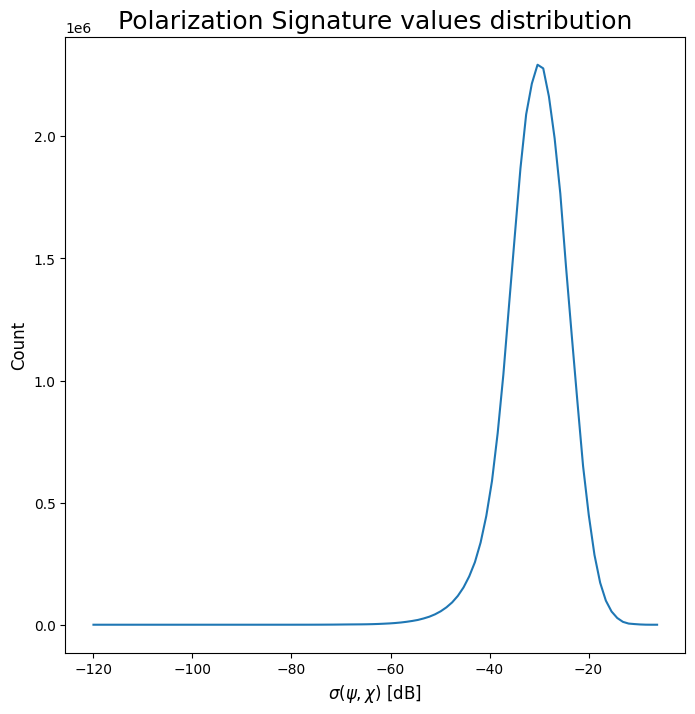

In [5]:
ax = plot_histogram(data_dB, hist_kw={"range":(-120, -5)})
ax.set_xlabel(r"$\sigma(\psi, \chi)$ [dB]")

### 1 - Train-Test split y Robust Scaler

Comenzamos separando en grupos de entrenamiento y testeo, para luego estandarizar los datos. En el estandarizado robusto, se resta la media de a cada feature -cada pixel se trata por separado considerandolo 1 feature-, y se divide por el interquartile rate.

In [6]:
train_set, test_set = train_test_split(
    data_dB, 
    test_size=.2, 
    random_state=123
    )

print(f'Tamaño de los datos de entrenamiento: {train_set.shape}')
print(f'Tamaño de los datos de testeo: {test_set.shape}')

Tamaño de los datos de entrenamiento: (5768, 45, 90)
Tamaño de los datos de testeo: (1443, 45, 90)


In [7]:
# Fiteo con el conjunto de entrenamiento
robust_scaler = RScaler().fit(train_set)

# Transformo ambos conjuntos
rscaled_train = robust_scaler.transform(train_set)
rscaled_test = robust_scaler.transform(test_set)

In [8]:
print(f"Conjunto de entrenamiento: mean={np.mean(rscaled_train)}, dev={np.std(rscaled_train)}")
print(f"Conjunto de testeo: mean={np.mean(rscaled_test)}, dev={np.std(rscaled_test)}")

Conjunto de entrenamiento: mean=0.006471995042465563, dev=0.700364983745136
Conjunto de testeo: mean=0.024059701857263572, dev=0.6908112028307883


Tomemos algún ejemplo al azar del conjunto de entrenamiento y visualicémoslo

<AxesSubplot:title={'center':'$\\sigma(\\psi,\\chi)$'}, xlabel='Orientation Angle $\\psi$ [°]', ylabel='Ellipticity Angle $\\chi$ [°]'>

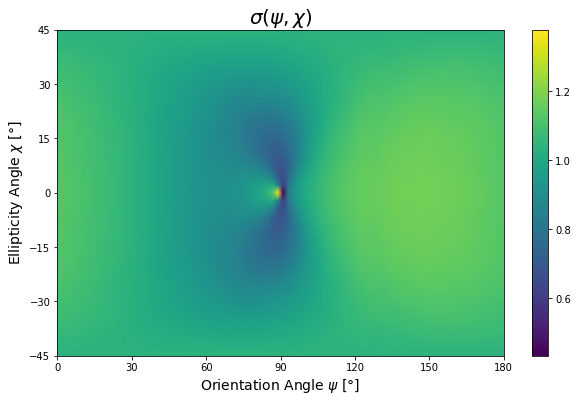

In [10]:
# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(rscaled_train.shape[0])
rnd_signature = rscaled_train[rnd_index, :, :]

# Ploteamos
plot_polarization_signature(rnd_signature)

Veamos un histograma de los conjuntos de entrenamiento y testeo

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

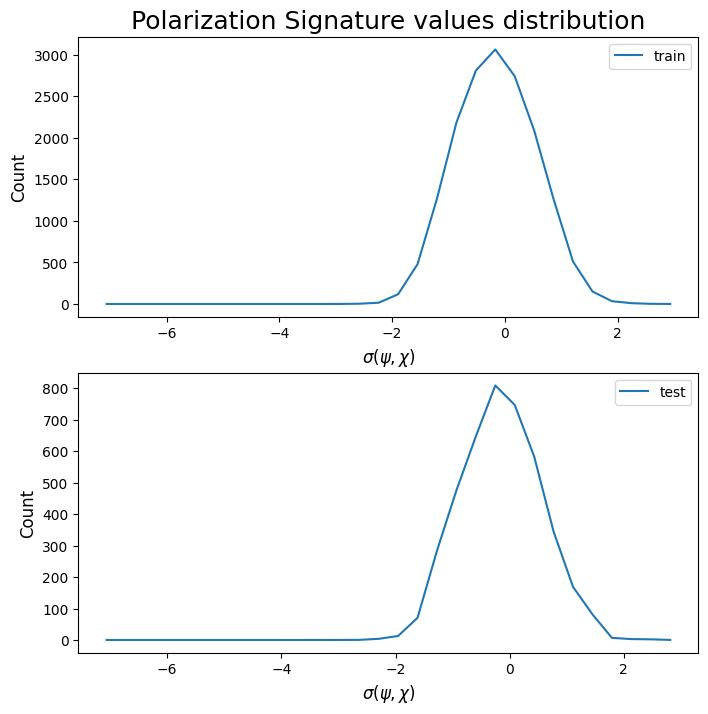

In [9]:
# Rango de valores válidos para los histogramas
train_range = np.min(rscaled_train), np.max(rscaled_train) 
test_range = np.min(rscaled_test), np.max(rscaled_test)

fig, ax1 = plt.subplots(2, 1, figsize=(20, 10))
plot_histogram(
    rscaled_train, 
    ax=ax1[0], 
    n_bins=30,
    hist_kw={'range' : train_range, 'density' : True}, 
    plot_kw={'label' : 'train'}
    )
plot_histogram(
    rscaled_test, 
    ax=ax1[1],
    n_bins=30, 
    hist_kw={'range' : test_range, 'density' : True}, 
    plot_kw={'label' : 'test'}
    )

ax1[1].set_title('')
for ax in ax1:
    ax.legend()

plt.tight_layout   

Agregamos una dimensión extra a nuestros arrays para que sirvan de entrada a una red convolucional.

In [10]:
rscaled_train = np.expand_dims(rscaled_train, axis=-1) 
rscaled_test = np.expand_dims(rscaled_test, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {rscaled_train.shape}')
print(f'Tamaño de los datos de testeo: {rscaled_test.shape}')

Tamaño de los datos de entrenamiento: (5768, 45, 90, 1)
Tamaño de los datos de testeo: (1443, 45, 90, 1)


Guardemos los datos estandarizados, y el objeto data scaler que usamos para volver a usarlo o desescalear los datos más adelante. 

In [12]:
# Robust Scaled signatures
rs_train_filename = "processed/spm_signatures_r_scale_train_set"
rs_test_filename = "processed/spm_signatures_r_scale_test_set"

save_data(rs_train_filename, rscaled_train)
save_data(rs_test_filename, rscaled_test)

Data saved at /home/jotavecorta/proyects/DeepScatteringModels/data/spm/processed/spm_signatures_r_scale_train_set.npy
Data saved at /home/jotavecorta/proyects/DeepScatteringModels/data/spm/processed/spm_signatures_r_scale_test_set.npy


In [13]:
# Persist model on disk
models_dir = os.path.normpath(os.getcwd() + "/../models")
scaler_path = os.path.join(models_dir, "robust_scaler.pkl")

with open(scaler_path, 'wb') as file_:
    pickle.dump(robust_scaler, file_)


### 2 -  Minmax Scaler

En vez de estandarizar los datos, probamos normalizarlos: los llevamos al intervalo $[0, 1]$.

In [14]:
# Fiteo con el conjunto de entrenamiento
minmax_scaler = MMScaler().fit(train_set)

# Transformo ambos conjuntos
mscaled_train = minmax_scaler.transform(train_set)
mscaled_test = minmax_scaler.transform(test_set)

In [15]:
print(f"Conjunto de entrenamiento: mean={np.mean(mscaled_train)}, dev={np.std(mscaled_train)}")
print(f"Conjunto de testeo: mean={np.mean(mscaled_test)}, dev={np.std(mscaled_test)}")

Conjunto de entrenamiento: mean=0.791626422747608, dev=0.06144864811111481
Conjunto de testeo: mean=0.7927434590447002, dev=0.061050298074238216


<AxesSubplot:title={'center':'$\\sigma(\\psi,\\chi)$'}, xlabel='Orientation Angle $\\psi$ [°]', ylabel='Ellipticity Angle $\\chi$ [°]'>

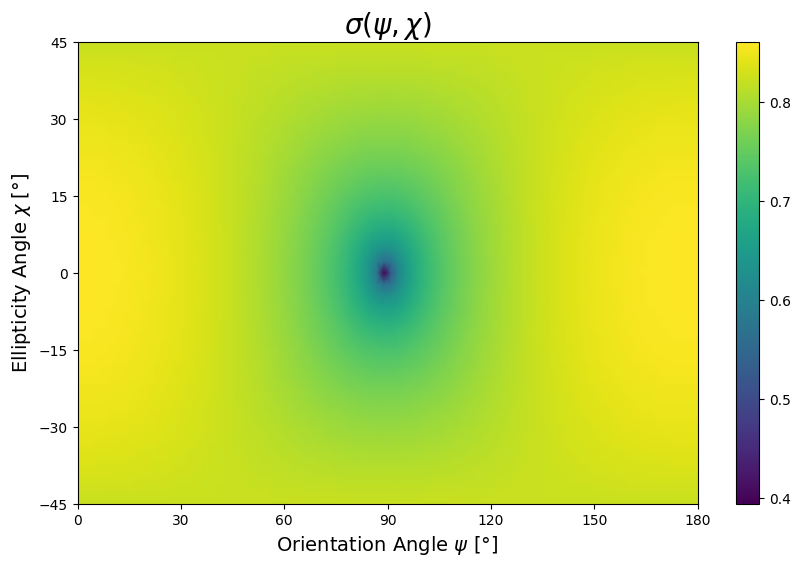

In [16]:
# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(mscaled_train.shape[0])
rnd_signature = mscaled_train[rnd_index, :, :]

# Ploteamos
plot_polarization_signature(rnd_signature)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

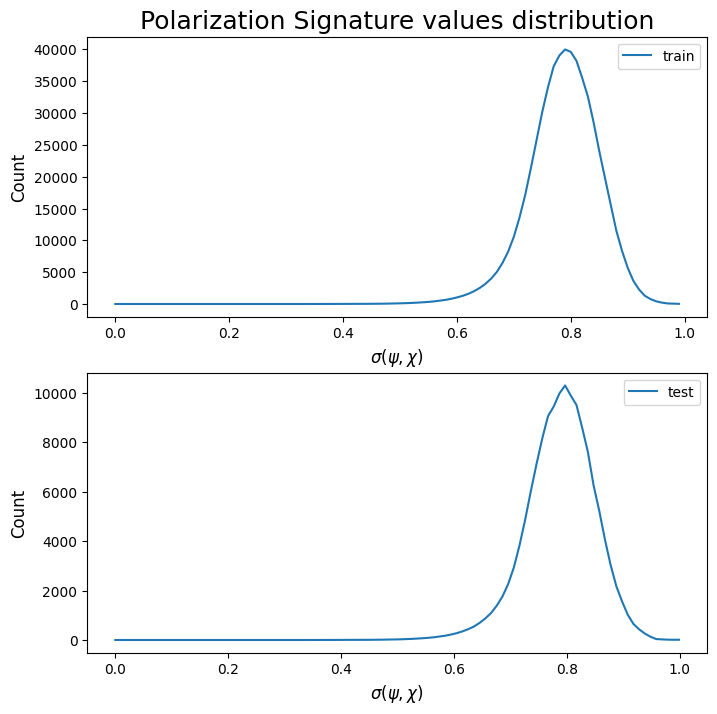

In [17]:
# Rango de valores válidos para los histogramas
train_range = np.min(mscaled_train), np.max(mscaled_train) 
test_range = np.min(mscaled_test), np.max(mscaled_test)

fig, ax1 = plt.subplots(2, 1, figsize=(20, 10))
plot_histogram(
    mscaled_train, 
    ax=ax1[0], 
    n_bins=100,
    hist_kw={'range' : train_range, 'density' : True}, 
    plot_kw={'label' : 'train'}
    )
plot_histogram(
    mscaled_test, 
    ax=ax1[1],
    n_bins=100, 
    hist_kw={'range' : test_range, 'density' : True}, 
    plot_kw={'label' : 'test'}
    )

ax1[1].set_title('')
for ax in ax1:
    ax.legend()

plt.tight_layout   

Agregamos una dimensión extra a nuestros arrays para que sirvan de entrada a una red convolucional.

In [18]:
mscaled_train =np.expand_dims(mscaled_train, axis=-1) 
mscaled_test = np.expand_dims(mscaled_test, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {mscaled_train.shape}')
print(f'Tamaño de los datos de testeo: {mscaled_test.shape}')

Tamaño de los datos de entrenamiento: (5768, 45, 90, 1)
Tamaño de los datos de testeo: (1443, 45, 90, 1)


Nuevamente guardamos los datos y el data scaler.

In [19]:
# Robust Scaled signatures
mm_train_filename = "processed/spm_signatures_m_scale_train_set"
mm_test_filename = "processed/spm_signatures_m_scale_test_set"

save_data(mm_train_filename, mscaled_train)
save_data(mm_test_filename, mscaled_test)

Data saved at /home/jotavecorta/proyects/DeepScatteringModels/data/spm/processed/spm_signatures_m_scale_train_set.npy
Data saved at /home/jotavecorta/proyects/DeepScatteringModels/data/spm/processed/spm_signatures_m_scale_test_set.npy


In [20]:
# Persist model on disk
models_dir = os.path.normpath(os.getcwd() + "/../models")
scaler_path = os.path.join(models_dir, "minmax_scaler.pkl")

with open(scaler_path, 'wb') as file_:
    pickle.dump(minmax_scaler, file_)


### 3 - Robust Scaler con un solo feature

En vez de comparar cada pixel por separado para cada realización, tomamos todos los pixels como distintos valores de un solo feature y estandarizamos con Robust Scaler

In [21]:
# Fiteo con el conjunto de entrenamiento
robust_scaler = RScaler_beta().fit(train_set)

# Transformo ambos conjuntos
beta_scaled_train = robust_scaler.transform(train_set)
beta_scaled_test = robust_scaler.transform(test_set)

In [22]:
print(f"Conjunto de entrenamiento: mean={np.mean(beta_scaled_train)}, dev={np.std(beta_scaled_train)}")
print(f"Conjunto de testeo: mean={np.mean(beta_scaled_test)}, dev={np.std(beta_scaled_test)}")

Conjunto de entrenamiento: mean=-0.043111165754633224, dev=0.792044123135687
Conjunto de testeo: mean=-0.028713094167435026, dev=0.7869095788396369


<AxesSubplot:title={'center':'$\\sigma(\\psi,\\chi)$'}, xlabel='Orientation Angle $\\psi$ [°]', ylabel='Ellipticity Angle $\\chi$ [°]'>

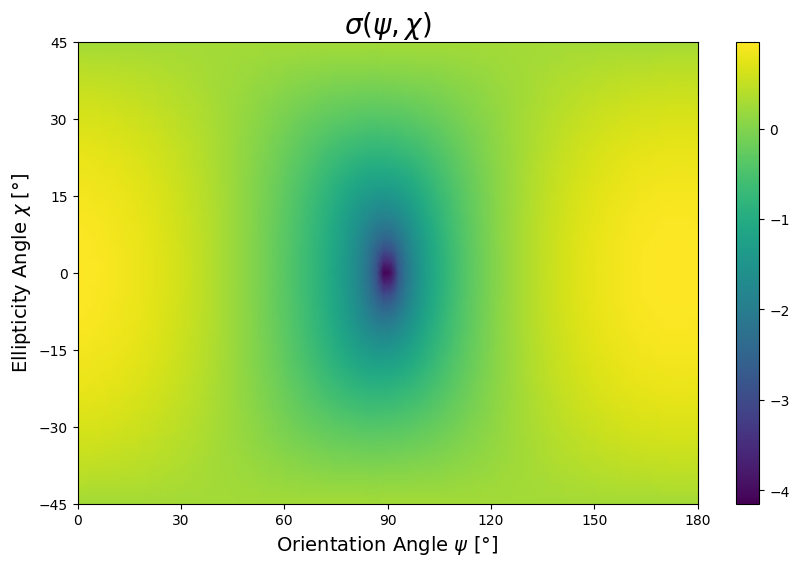

In [23]:
# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(beta_scaled_train.shape[0])
rnd_signature = beta_scaled_train[rnd_index, :, :]

# Ploteamos
plot_polarization_signature(rnd_signature)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

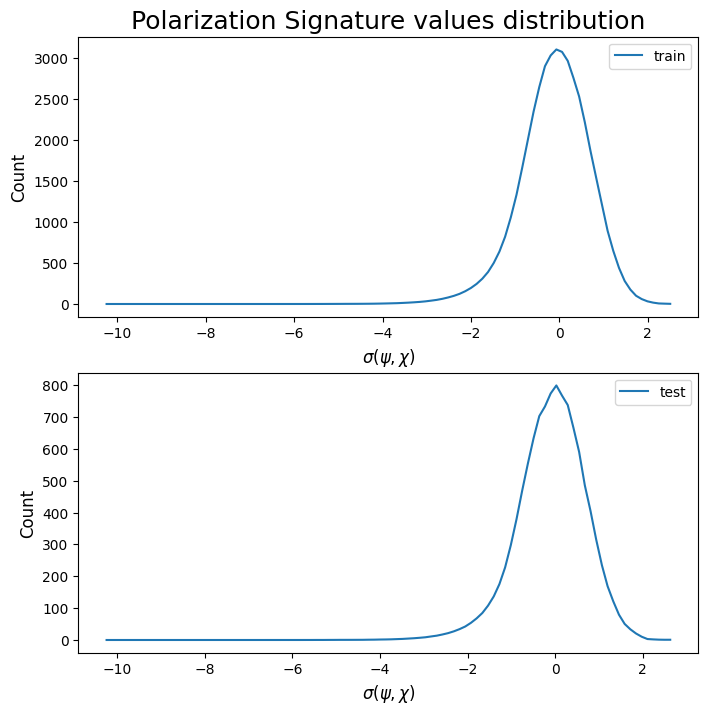

In [24]:
# Rango de valores válidos para los histogramas
train_range = np.min(beta_scaled_train), np.max(beta_scaled_train) 
test_range = np.min(beta_scaled_test), np.max(beta_scaled_test)

fig, ax1 = plt.subplots(2, 1, figsize=(20, 10))
plot_histogram(
    beta_scaled_train, 
    ax=ax1[0], 
    n_bins=100,
    hist_kw={'range' : train_range, 'density' : True}, 
    plot_kw={'label' : 'train'}
    )
plot_histogram(
    beta_scaled_test, 
    ax=ax1[1],
    n_bins=100, 
    hist_kw={'range' : test_range, 'density' : True}, 
    plot_kw={'label' : 'test'}
    )

ax1[1].set_title('')
for ax in ax1:
    ax.legend()

plt.tight_layout   

Guardemos los datos estandarizados, y el objeto data scaler que usamos para volver a usarlo o desescalear los datos más adelante. 

In [25]:
beta_scaled_train = np.expand_dims(beta_scaled_train, axis=-1) 
beta_scaled_test = np.expand_dims(beta_scaled_test, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {beta_scaled_train.shape}')
print(f'Tamaño de los datos de testeo: {beta_scaled_test.shape}')

Tamaño de los datos de entrenamiento: (5768, 45, 90, 1)
Tamaño de los datos de testeo: (1443, 45, 90, 1)


In [26]:
# Robust Scaled signatures
beta_train_filename="processed/spm_signatures_beta_scale_train_set"
beta_test_filename="processed/spm_signatures_beta_scale_test_set"

save_data(beta_train_filename, beta_scaled_train)
save_data(beta_test_filename, beta_scaled_test)

Data saved at /home/jotavecorta/proyects/DeepScatteringModels/data/spm/processed/spm_signatures_beta_scale_train_set.npy
Data saved at /home/jotavecorta/proyects/DeepScatteringModels/data/spm/processed/spm_signatures_beta_scale_test_set.npy


In [27]:
# Persist model on disk
models_dir = os.path.normpath(os.getcwd() + "/../models")
scaler_path = os.path.join(models_dir, "beta_robust_scaler.pkl")

with open(scaler_path, 'wb') as file_:
    pickle.dump(robust_scaler, file_)
